## Imports

In [33]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy
from tqdm.notebook import tqdm
import sys

import pickle
import re
import pyLDAvis
import pyLDAvis.gensim
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

import wordcloud
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm
from collections import Counter

nlp = spacy.load('en_core_web_sm')


## Data Loading

In [ ]:
df_dataset = pd.read_csv('df_dataset.csv', index_col = 0)
clean_facts = df_dataset['cleaned_facts']
clean_facts

## Data Preprocessing

In [3]:
def further_preprocessing(text):

    # Convert the text to lowercase
    text = text.lower()

    # Remove anything that is not a word or space
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Lemmatize the text
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    # Remove single character strings
    tokens = [token for token in tokens if len(token) > 1]

    text = " ".join(tokens)

    # Remove the word "applicant"
    text = re.sub(r'\bapplicant\b', '', text)

    # Remove duplicate whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove any extra leading or trailing whitespace left after processing
    text = text.strip()
    
    return text

In [ ]:
clean_facts = clean_facts.apply(further_preprocessing)
clean_facts

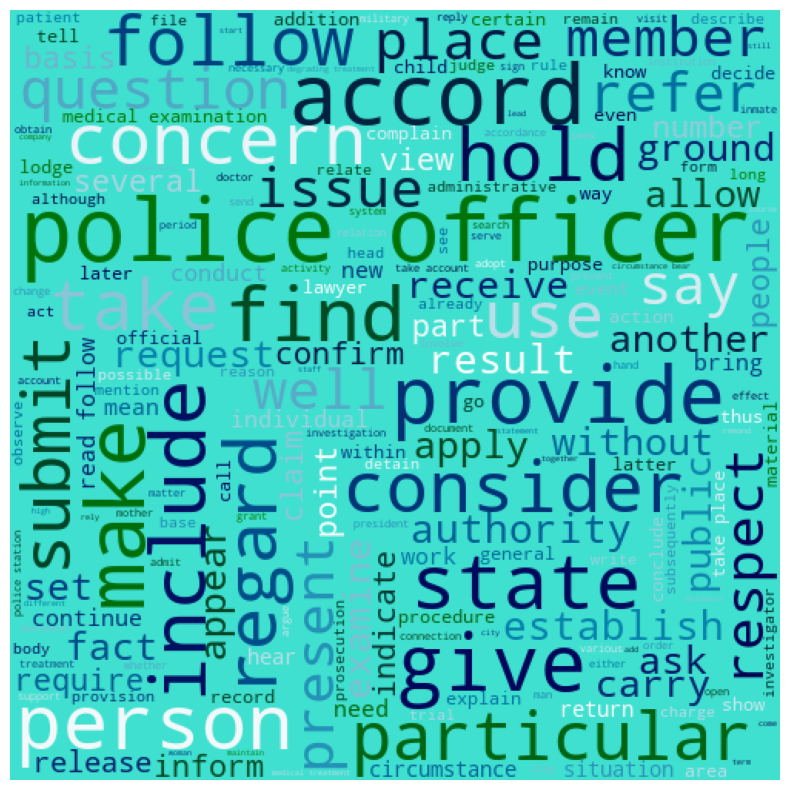

In [6]:
facts_data = ""
for fact in clean_facts:
    facts_data = facts_data+" "+fact

#ploting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(facts_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [5]:
# If min_count=5, only those bigrams that appear at least 5 times in the corpus will be considered. 
#  Threshold controls how selective the model is in forming phrases. A higher threshold means that only word pairs with a strong association (high score) will be combined into a phrase
# https://stackoverflow.com/questions/46148182/issues-in-getting-trigrams-using-gensim

sentence_stream = [doc.split(" ") for doc in clean_facts]

bigram = gensim.models.Phrases(sentence_stream, min_count=5, threshold = 20)  

In [6]:
def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

In [ ]:
clean_facts_bigrams = make_bigrams(sentence_stream)
clean_facts_bigrams

## Metric Functions

### Calculate Coherence

In [8]:
def compute_coherence_values_lda(facts, corpus, dictionary, k, a, b):
    lda_model = LdaModel(corpus=corpus, num_topics=k,
                                id2word=dictionary, passes=10,
                                alpha=a, eta=b, chunksize=100,
                                per_word_topics=True, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=facts,
                                         dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()


### Calculate Diversity

In [9]:
def calculate_topic_diversity(model, top_n):

    topic_words = []
    for topic_id in range(model.num_topics):
        words = [word for word, _ in model.show_topic(topic_id, topn=top_n)]
        topic_words.append(words)
    
    all_words = [word for sublist in topic_words for word in sublist]
    unique_words = set(all_words)
    
    topic_diversity = len(unique_words) / (model.num_topics * top_n)
    
    return topic_diversity


Standalone coherence calculation to validate the value

In [10]:
def calculate_coherence(model, facts, dictionary,metric):
    coherence_model = CoherenceModel(model=model, texts=facts,
                                        dictionary=dictionary, coherence=metric)
    return coherence_model.get_coherence()  

Calculating topic diversity for all the instances

In [16]:
def calculate_topic_diversity_for_row(row, corpus, dictionary):
    # Ensure that the parameters are integers
    k = int(row['Topics'])
    alpha = row['Alpha']
    beta = row['Beta']

    lda_model = LdaModel(corpus=corpus, num_topics=k,
                                id2word=dictionary, passes=10,
                                alpha=alpha, eta=beta, chunksize=100,
                                per_word_topics=True, random_state=42)
    
    return calculate_topic_diversity(lda_model, top_n=10)

### Set max_df

In [ ]:
# Setting no_above = max_df will remove words that appear in more than max_df% of the documents
def remove_frequent(facts, max_df):
    dictionary = corpora.Dictionary(facts)
    if max_df <1:
        dictionary.filter_extremes(no_above=max_df)
    corpus = [dictionary.doc2bow(text) for text in facts]
    return dictionary, corpus

### Perform Grid Search

In [13]:
def run_tests(min_topics, max_topics, facts, dictionary, corpus):
    grid = {}

    # Topic number
    step_size = 1
    topics_range = range(min_topics, max_topics+1, step_size)

    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')

    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')


    # results dictionary
    model_results = {
                    'Topics': [],
                    'Alpha': [],
                    'Beta': [],
                    'Coherence': []
                    }

    total_iterations = len(topics_range) * len(alpha) * len(beta)

    with tqdm(total=total_iterations) as pbar:
        for k in topics_range:   
            for a in alpha:       
                for b in beta:    
                    cv = compute_coherence_values_lda(facts=facts, corpus=corpus,
                                                  dictionary=dictionary,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    # Update the progress bar
                    pbar.update(1)

    # save the results to a dataframe
    return pd.DataFrame(model_results)

In [14]:
dictionary_0_3_new, corpus_0_3_new = remove_frequent(clean_facts_bigrams,0.3)
df_0_3_new = run_tests(1,20,clean_facts_bigrams, dictionary_0_3_new, corpus_0_3_new)

100%|██████████| 600/600 [2:35:26<00:00, 15.54s/it]  


In [18]:
df_0_3_new.sort_values(by='Coherence', ascending=False).head(30)

,Topics,Alpha,Beta,Coherence
578,20,0.31,0.91,0.664126
283,10,0.61,0.91,0.643539
583,20,0.61,0.91,0.635053
328,11,asymmetric,0.91,0.634497
327,11,asymmetric,0.61,0.628265
223,8,0.61,0.91,0.626399
308,11,0.31,0.91,0.626312
323,11,symmetric,0.91,0.624373
217,8,0.31,0.61,0.623134
257,9,0.91,0.61,0.622657


In [17]:
df_0_3_new['Topic Diversity'] = df_0_3_new.apply(lambda row: calculate_topic_diversity_for_row(row, corpus_0_3_new, dictionary_0_3_new), axis=1)

df_0_3_sorted_by_diversity = df_0_3_new.sort_values(by='Topic Diversity', ascending=False)
df_0_3_sorted_by_diversity.to_csv('df_0_3_sorted_by_diversity_lda_all.csv')

In [20]:
best_model_0_3_new_top20 = LdaModel(corpus=corpus_0_3_new, num_topics=10,
                                id2word=dictionary_0_3_new, passes=10,
                                alpha=0.61, eta=0.91, chunksize=100,
                                per_word_topics=True, random_state=42)

pprint(best_model_0_3_new_top20.print_topics(num_words=30))

[(0,
  '0.009*"secret" + 0.007*"operation" + 0.006*"transport" + 0.005*"military" + '
  '0.005*"aircraft" + 0.005*"territory" + 0.005*"source" + 0.004*"flight" + '
  '0.004*"site" + 0.004*"control" + 0.003*"president" + 0.003*"former" + '
  '0.003*"inquiry" + 0.003*"security" + 0.003*"redact" + 0.003*"plan" + '
  '0.003*"passenger" + 0.003*"foreign" + 0.003*"location" + 0.003*"plane" + '
  '0.003*"service" + 0.003*"rendition" + 0.003*"camp" + 0.003*"interrogator" + '
  '0.003*"route" + 0.002*"operate" + 0.002*"technique" + 0.002*"terrorist" + '
  '0.002*"terrorism" + 0.002*"secretary"'),
 (1,
  '0.010*"removal" + 0.009*"expulsion" + 0.008*"immigration" + '
  '0.008*"deportation" + 0.007*"extradition" + 0.006*"territory" + '
  '0.006*"refugee" + 0.005*"migrant" + 0.005*"residence_permit" + '
  '0.005*"national" + 0.005*"border" + 0.005*"passport" + 0.004*"arrival" + '
  '0.004*"centre" + 0.004*"death" + 0.004*"certificate" + 0.004*"seeker" + '
  '0.004*"registration" + 0.004*"foreign_na

In [ ]:
calculate_topic_diversity(best_model_0_3_new_top20,10)

0.95

In [22]:
coherence_lda = calculate_coherence(best_model_0_3_new_top20, clean_facts_bigrams, )
print('Coherence Score:', coherence_lda)

Coherence Score: 0.643538743632174


In [24]:
pyLDAvis.enable_notebook()
p = gensimvis.prepare(best_model_0_3_new_top20, corpus_0_3_new, dictionary_0_3_new, mds='mmds')
p


/Users/XXXX-1/XXXX-3/ECHR/tutorials/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=77610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/XXXX-1/XXXX-3/ECHR/tutorials/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=77610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/XXXX-1/XXXX-3/ECHR/tutorials/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=77610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/XXXX-1/XXXX-3/ECHR/tutorials/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=77610) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/XXXX-1/XXXX-3/ECH

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.122551 -0.051050       1        1  23.869325
9     -0.017610 -0.229557       2        1  20.275683
4     -0.247439 -0.003206       3        1  13.362044
3     -0.085764  0.238866       4        1  10.141058
7      0.187545 -0.139741       5        1   8.914465
5      0.199884  0.077523       6        1   8.892853
0      0.010286  0.016833       7        1   6.362044
8     -0.104886 -0.119150       8        1   3.832918
1     -0.111064  0.070820       9        1   3.494984
2      0.046497  0.138663      10        1   0.854625, topic_info=             Term         Freq        Total Category  logprob  loglift
552         child  2035.000000  2035.000000  Default  30.0000  30.0000
812       patient  1703.000000  1703.000000  Default  29.0000  29.0000
3389       remand  1962.000000  1962.000000  Default  28.0000  28.0000
1247     military  1185.000000  1185.000000  Default  27.0000  27.0000
185          beat  1829.000000  1829.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
964        travel    13.742033   384.375135  Topic10  -6.3178   1.4311
1481         move    13.896906   654.976956  Topic10  -6.3066   0.9093
264   enforcement    10.889440   507.708831  Topic10  -6.5505   0.9201
1568   permission    10.478296   438.879765  Topic10  -6.5889   1.0273
181     authorise     9.506351   940.910099  Topic10  -6.6863   0.1674

[608 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
7627      1  0.853782  abolition
7627      2  0.010044  abolition
7627      3  0.010044  abolition
7627      4  0.010044  abolition
7627      5  0.010044  abolition
...     ...       ...        ...
2309      6  0.015426       zone
2309      7  0.092559       zone
2309      8  0.051422       zone
2309      9  0.637628       zone
2309     10  0.005142       zone

[5079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 5, 4, 8, 6, 1, 9, 2, 3])

## Results Plotting

### Cases with highest percentages of topic distributions

In [74]:
topic_distributions = [best_model_0_3_new_top20.get_document_topics(doc) for doc in corpus_0_3_new]


In [75]:
topic_df = pd.DataFrame([
    {f"Topic_{i}": prob for i, prob in doc_topics}
    for doc_topics in topic_distributions
])

In [76]:
topic_df

,Topic_6,Topic_7,Topic_8,Topic_9,Topic_3,Topic_5,Topic_0,Topic_1,Topic_4,Topic_2
0,0.208846,0.310286,0.435019,0.024116,NaN,NaN,NaN,NaN,NaN,NaN
1,0.058480,NaN,NaN,0.844847,0.026388,0.054200,NaN,NaN,NaN,NaN
2,0.244796,0.010580,NaN,NaN,0.183498,0.556109,NaN,NaN,NaN,NaN
3,0.022343,NaN,0.428819,0.516255,NaN,0.024264,NaN,NaN,NaN,NaN
4,0.083970,NaN,NaN,0.647751,NaN,0.178536,0.034631,0.032548,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1336,NaN,NaN,NaN,NaN,NaN,NaN,0.112758,NaN,0.878805,NaN
1337,0.193760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.801486,NaN
1338,NaN,NaN,NaN,NaN,0.311250,NaN,NaN,NaN,0.653109,NaN
1339,0.032427,NaN,NaN,NaN,0.944207,NaN,NaN,NaN,NaN,NaN


In [79]:
top_cases_per_topic = {}
for topic_num in range(best_model_0_3_new_top20.num_topics):
    # Sort the documents by the proportion of the current topic
    top_cases = topic_df.nlargest(6, f'Topic_{topic_num}').index
    top_cases_per_topic[f'Topic_{topic_num}'] = df_dataset.iloc[top_cases]


In [101]:
for topic, cases in top_cases_per_topic.items():
    print(f"\nTop 6 cases for {topic}:")
    display(cases[['appno', 'docname']])


Top 6 cases for Topic_0:


,appno,docname
691,33234/12,CASE OF AL NASHIRI v. ROMANIA
552,7511/13,CASE OF HUSAYN (ABU ZUBAYDAH) v. POLAND
270,28761/11,CASE OF AL NASHIRI v. POLAND
189,46454/11,CASE OF ABU ZUBAYDAH v. LITHUANIA
783,39630/09,"CASE OF EL-MASRI v. ""THE FORMER YUGOSLAV REPUB..."
770,44437/21;46219/21;46407/21;46550/21;46613/21;4...,CASE OF GRISHIN AND OTHERS v. RUSSIA



Top 6 cases for Topic_1:


,appno,docname
1309,14594/07;14597/07;14976/07;14978/07;15221/07;1...,CASE OF BERDZENISHVILI AND OTHERS v. RUSSIA
1231,61411/15;61420/15;61427/15;3028/16,CASE OF Z.A. AND OTHERS v. RUSSIA
1321,21896/08,CASE OF Z.N.S. v. TURKEY
891,52160/13;52165/13,CASE OF MOXAMED ISMAACIIL AND ABDIRAHMAN WARSA...
1078,61411/15;61420/15;61427/15;3028/16,CASE OF Z.A. AND OTHERS v. RUSSIA
757,16483/12,CASE OF KHLAIFIA AND OTHERS v. ITALY



Top 6 cases for Topic_2:


,appno,docname
842,27238/95,CASE OF CHAPMAN v. THE UNITED KINGDOM
427,25289/94,CASE OF LEE v. THE UNITED KINGDOM
676,25154/94,CASE OF JANE SMITH v. THE UNITED KINGDOM
592,24876/94,CASE OF COSTER v. THE UNITED KINGDOM
531,24882/94,CASE OF BEARD v. THE UNITED KINGDOM
199,17647/04,CASE OF EDWARDS v. MALTA



Top 6 cases for Topic_3:


,appno,docname
973,66583/11,CASE OF BUDANOV v. RUSSIA
927,46404/13,CASE OF KHLOYEV v. RUSSIA
953,41828/10,CASE OF GURENKO v. RUSSIA
968,32863/13,CASE OF LITVINOV v. RUSSIA
1327,58530/08,CASE OF NOGIN v. RUSSIA
912,44694/13,CASE OF KOLESNIKOVICH v. RUSSIA



Top 6 cases for Topic_4:


,appno,docname
120,43710/07;11248/08;27668/08;31242/08;52133/08;6...,CASE OF FETISOV AND OTHERS v. RUSSIA
250,36932/02,CASE OF BAKHMUTSKIY v. RUSSIA
1313,3130/03,CASE OF SUDARKOV v. RUSSIA
747,7772/04,CASE OF VLADIMIR KRIVONOSOV v. RUSSIA
282,20641/04,CASE OF CHUDUN v. RUSSIA
829,29464/03,CASE OF AREFYEV v. RUSSIA



Top 6 cases for Topic_5:


,appno,docname
1122,37359/09,CASE OF H. v. FINLAND
628,37359/09,CASE OF HÄMÄLÄINEN v. FINLAND
907,15766/03,CASE OF ORŠUŠ AND OTHERS v. CROATIA
1106,61495/11,CASE OF M.G.C. v. ROMANIA
1147,7144/15,CASE OF A AND B v. CROATIA
385,54032/18,CASE OF T.C. v. ITALY



Top 6 cases for Topic_6:


,appno,docname
1339,21906/04,CASE OF KAFKARIS v. CYPRUS
275,20261/12,CASE OF BAKA v. HUNGARY
151,49570/11,CASE OF GÁLL v. HUNGARY
1170,41838/11,CASE OF R.Sz. v. HUNGARY
1176,49868/19;57511/19,CASE OF DOLIŃSKA-FICEK AND OZIMEK v. POLAND
56,66529/11,CASE OF N.K.M. v. HUNGARY



Top 6 cases for Topic_7:


,appno,docname
1311,3642/10,CASE OF MUKHIN v. RUSSIA
1326,8918/05,CASE OF GREBNEVA AND ALISIMCHIK v. RUSSIA
1283,20928/05,CASE OF PETRENCO v. MOLDOVA
557,60183/17,CASE OF PRICOPE v. ROMANIA
493,12996/12;35043/13,CASE OF NOVAYA GAZETA AND OTHERS v. RUSSIA
1329,38435/05,CASE OF BODROZIC AND VUJIN v. SERBIA



Top 6 cases for Topic_8:


,appno,docname
423,50043/14,CASE OF KOVYAZIN v. RUSSIA
1247,30582/04;32152/04,CASE OF KARPYUK AND OTHERS v. UKRAINE
865,30587/13,CASE OF KARAAHMED v. BULGARIA
735,7469/06,CASE OF CANGÖZ AND OTHERS v. TURKEY
1290,15367/14;16280/14;18118/14;20546/14;24405/14;3...,CASE OF SHMORGUNOV AND OTHERS v. UKRAINE
506,18299/03;27311/03,CASE OF FINOGENOV AND OTHERS v. RUSSIA



Top 6 cases for Topic_9:


,appno,docname
1006,17828/05,CASE OF OCHELKOV v. RUSSIA
1325,58040/08,CASE OF LOLAYEV v. RUSSIA
1317,44153/15,CASE OF SKORUPA v. POLAND
370,21048/12,CASE OF GEDRIMAS v. LITHUANIA
331,62003/08;27965/10;4878/15;32572/16;6809/18;350...,CASE OF KURSISH AND OTHERS v. RUSSIA
256,5666/07;12892/08;5264/10;21396/11;51153/14,CASE OF ZAGAYNOV AND OTHERS v. RUSSIA


### Number of Documents per Topic

In [31]:
most_prevalent_topics = [max(doc_topics, key=lambda x: x[1])[0] for doc_topics in topic_distributions]

topic_counts = Counter(most_prevalent_topics)

for topic_num, count in sorted(topic_counts.items()):
    print(f"Topic {topic_num}: {count} documents")


Topic 0: 61 documents
Topic 1: 44 documents
Topic 2: 5 documents
Topic 3: 150 documents
Topic 4: 276 documents
Topic 5: 95 documents
Topic 6: 204 documents
Topic 7: 129 documents
Topic 8: 28 documents
Topic 9: 349 documents
1341


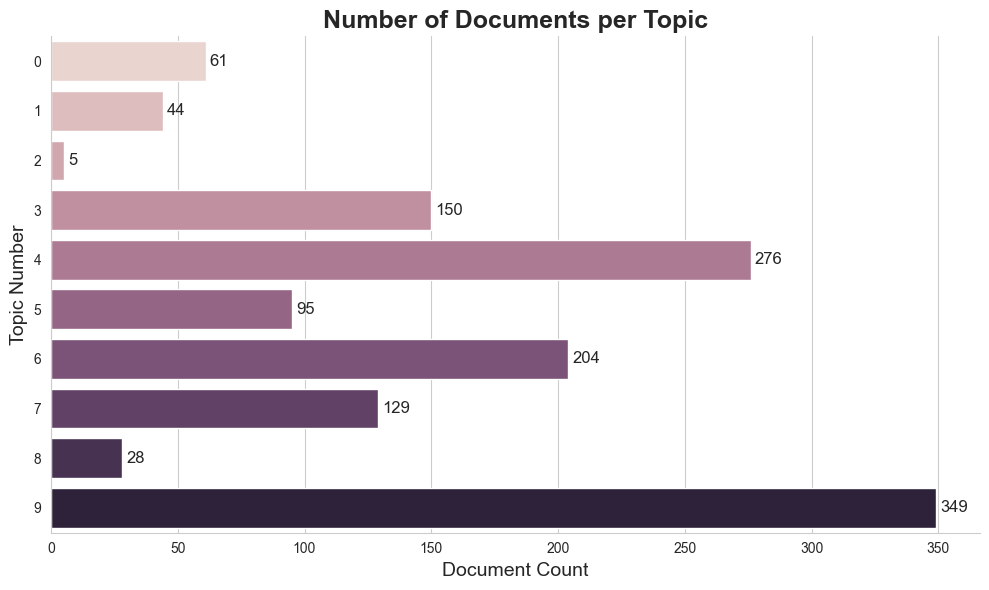

In [100]:
topic_df = pd.DataFrame(list(topic_counts.items()), columns=['Topic', 'Count'])
topic_df = topic_df.sort_values('Topic')

plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Count', y='Topic', hue = 'Topic', data=topic_df, orient = 'h', dodge=False)

ax.set_title('Number of Documents per Topic', fontsize=18, weight='bold')
ax.set_xlabel('Document Count', fontsize=14)
ax.set_ylabel('Topic Number', fontsize=14)

ax.legend_.remove()

for i in ax.containers:
    ax.bar_label(i, fmt='%d', fontsize=12, padding=3)


sns.despine()

plt.tight_layout()

plt.show()

In [43]:
df = pd.read_csv('df_merged.csv', index_col = 0)
df.head()

,itemid,docname,appno,judgementdate,law,facts,conclusion,full_text,judgement_type,textrank_summary,...,textrank_ne_removed,cleaned_facts,cleaned_bertsum,cleaned_textrank,cleaned_facts_pos_removed,cleaned_bertsum_pos_removed,cleaned_textrank_pos_removed,respondent,caseyear,article
0,001-209033,CASE OF HANDZHIYSKI v. BULGARIA,10783/14,06/04/2021 00:00:00,### THE LAW\n\n- ALLEGED VIOLATION OF ARTICLE ...,THE FACTS 2. The applicant was born in 1971 a...,"### FOR THESE REASONS, THE COURT\n\n- Declares...",FOURTH SECTIONCASE OF HANDZHIYSKI v. BULGARIA(...,CHAMBER,['Following parliamentary elections on 12 May ...,...,"['Following parliamentary elections on , on ...",. born lives . represented . Ekimdz...,"['Together, provided majority total ...","['Following parliamentary elections , new ...",". lives . . Ekimdzhiev , lawyers . . Agent , ....","[ 'Together , majority members . ' , ' another...","[ elections , , Plamen ( whose member – ) , me...",BULGARIA,2021,"['35', '41', '10']"
1,001-153349,CASE OF NALBANDYAN v. ARMENIA,9935/06;23339/06,31/03/2015 00:00:00,### THE LAW\n\n- I. JOINDER OF THE APPLICATIO...,THE FACTS I. THE CIRCUMSTANCES OF THE CASE 5....,"### FOR THESE REASONS, THE COURT UNANIMOUSLY\n...",THIRD SECTION CASE OF NALBANDYAN v. ARMENIA (A...,CHAMBER,"['In doing so, the examined and dismissed the ...",...,"['In doing so, the examined and dismissed the ...",". CIRCUMSTANCES . applicants born , ...",[' applicants formally arrested connec...,"[' , examined dismissed applicants’ all...",". CIRCUMSTANCES . applicants , respectively . ...",[ ' applicants formally connection murder . ' ...,"[ ' , applicants allegations grounds : ( ) all...",ARMENIA,2015,"['3', '6']"
2,001-104911,CASE OF R.R. v. POLAND,27617/04,26/05/2011 00:00:00,### THE LAW\n\n- 90. The applicant complained...,THE FACTS I. THE CIRCUMSTANCES OF THE CASE 6....,"### FOR THESE REASONS, THE COURT\n\n- 1. Join...",FOURTH SECTION CASE OF R.R. v. POLAND (Applica...,CHAMBER,"['The Assembly also notes that, in member stat...",...,"['The also that, in member where abortion i...",. CIRCUMSTANCES . born . . Early v...,"[' admitted ., within covered , ...","[' , member abortion permitted number...",". CIRCUMSTANCES . . . B . . , ( later ) . , B....","[ ' . , within , advice . ' , ' doctors B. , R...","[ ' , member abortion number reasons , always ...",POLAND,2011,"['41', '3', '8', '35', '34']"
3,001-150648,CASE OF CIORCAN AND OTHERS v. ROMANIA,29414/09;44841/09,27/01/2015 00:00:00,### THE LAW\n\n- I. JOINDER OF THE APPLICATIO...,THE FACTS I. THE CIRCUMSTANCES OF THE CASE 5....,"### FOR THESE REASONS, THE COURT, UNANIMOUSLY,...",THIRD SECTION CASE OF CIORCAN AND OTHERS v. RO...,CHAMBER,['The following twentytwo applicants: Ştefan B...,...,"[' applicants: , , , , , (Biga), , , , (Big...",. CIRCUMSTANCES . applicants thirtyseven...,"[' considered require medical treatment.',...","[' applicants: , , , , , (Biga), , , , (Big...",. CIRCUMSTANCES . applicants nationals . neigh...,"[ ' treatment . ' , ' certificate , wound exco...","[ ' applicants : , , , , , ( Biga ) , , , , ( ...",ROMANIA,2015,"['2', '3', '14']"
4,001-83882,CASE OF PETROPOULOU-TSAKIRIS v. GREECE,44803/04,06/12/2007 00:00:00,### THE LAW\n\n- I. ALLEGED VIOLATION OF ARTI...,THE FACTS I. THE CIRCUMSTANCES OF THE CASE 5....,"### FOR THESE REASONS, THE COURT\n\n- 1. Join...",FIRST SECTION CASE OF PETROPOULOUTSAKIRIS v. G...,CHAMBER,"['On 1 May 2002 two police officers, the head ...",...,"['On police officers, the head of the secu...",. CIRCUMSTANCES . ethnic origin live...,"[' . CIRCUMSTANCES .', ' , . ., ...","[' police officers, head security po...",". CIRCUMSTANCES . origin lives , ( ) , settlem...","[ ' . CIRCUMSTANCES . ' , ' , . . , , police s...","[ ' police officers , security police station ...",GREECE,2007,"['3', '35', '41', '14']"


### Most likely topic by country

In [65]:
df['most likely topic'] = most_prevalent_topics

topic_by_country = df.groupby(['respondent', 'most likely topic']).size().reset_index(name='count')

most_likely_topic_by_country = topic_by_country.loc[topic_by_country.groupby('respondent')['count'].idxmax()]
most_likely_topic_by_country.reset_index(drop=True, inplace=True)
most_likely_topic_by_country

,respondent,most likely topic,count
0,"""THE FORMER YUGOSLAV REPUBLIC OF MACEDONIA""",9,4
1,ALBANIA,4,1
2,ANDORRA,5,1
3,ARMENIA,9,8
4,AUSTRIA,9,3
5,AZERBAIJAN,9,14
6,BELGIUM,6,5
7,BELGIUM AND GREECE,6,1
8,BOSNIA AND HERZEGOVINA,6,2
9,BULGARIA,9,15


In [66]:
filtered_most_likely_topic_by_country = most_likely_topic_by_country[most_likely_topic_by_country['count'] > 2]
filtered_most_likely_topic_by_country.reset_index(drop=True, inplace=True)
filtered_most_likely_topic_by_country

,respondent,most likely topic,count
0,"""THE FORMER YUGOSLAV REPUBLIC OF MACEDONIA""",9,4
1,ARMENIA,9,8
2,AUSTRIA,9,3
3,AZERBAIJAN,9,14
4,BELGIUM,6,5
5,BULGARIA,9,15
6,CROATIA,9,13
7,CYPRUS,6,4
8,ESTONIA,4,5
9,FINLAND,5,3


### Most likely topic by year

In [68]:
topic_by_year = df.groupby(['caseyear', 'most likely topic']).size().reset_index(name='count')

most_likely_topic_by_year = topic_by_year.loc[topic_by_year.groupby('caseyear')['count'].idxmax()]
most_likely_topic_by_year.reset_index(drop=True, inplace=True)
most_likely_topic_by_year

,caseyear,most likely topic,count
0,1978,6,1
1,1979,5,1
2,1982,5,1
3,1983,6,1
4,1985,6,1
5,1989,6,2
6,1991,6,1
7,1993,5,2
8,1994,6,1
9,1995,5,2


In [69]:
filtered_most_likely_topic_by_year = most_likely_topic_by_year[most_likely_topic_by_year['count'] > 2]
filtered_most_likely_topic_by_year.reset_index(drop=True, inplace=True)
filtered_most_likely_topic_by_year

,caseyear,most likely topic,count
0,2000,9,4
1,2001,6,6
2,2002,6,4
3,2003,1,6
4,2004,6,7
5,2005,4,11
6,2006,4,7
7,2007,9,15
8,2008,4,19
9,2009,9,26


### Most common article violation per topic 

In [58]:
df['most_likely_topic'] = [max(doc_topics, key=lambda x: x[1])[0] for doc_topics in topic_distributions]

In [59]:
df_exploded = df.explode('article')

df_exploded['article'] = df_exploded['article'].apply(lambda x: eval(x) if isinstance(x, str) else x)

df_exploded = df_exploded.explode('article')

topic_article_counts = df_exploded.groupby(['most_likely_topic', 'article']).size().reset_index(name='count')

most_common_article_by_topic = topic_article_counts.loc[topic_article_counts.groupby('most_likely_topic')['count'].idxmax()]
most_common_article_by_topic.set_index('most_likely_topic', inplace=True)
most_common_article_by_topic.index.name = 'Topic Number'

most_common_article_by_topic

,article,count
Topic Number,,
0,3,60
1,3,40
2,14,5
3,3,132
4,3,271
5,8,62
6,41,123
7,10,102
8,3,18
